# German Traffic Sign Classification

---

In [1]:
%matplotlib inline

import numpy as np
import matplotlib
from matplotlib import pyplot
import tensorflow as tf

In [2]:
from skimage.transform import ProjectiveTransform, rotate, warp
import random

In [11]:
image_size = 100
d = 10

tl_top = random.uniform(-d, d)     # Top left corner, top
tl_left = random.uniform(-d, d)    # Top left corner, left
bl_bottom = random.uniform(-d, d)  # Bot left corner, bot
bl_left = random.uniform(-d, d)    # Bot left corner, left
tr_top = random.uniform(-d, d)     # Top right corner, top
tr_right = random.uniform(-d, d)   # Top right corner, right
br_bottom = random.uniform(-d, d)  # Bot right corner, bot
br_right = random.uniform(-d, d)   # Bot right corner, right

transform = ProjectiveTransform()
transform.estimate(np.array((
    (tl_left, tl_top),
    (bl_left, image_size - bl_bottom),
    (image_size - br_right, image_size - br_bottom),
    (image_size - tr_right, tr_top)
)), np.array((
    (0, 0),
    (0, image_size),
    (image_size, image_size),
    (image_size, 0)
)))

True

In [17]:
transform.params

array([[  9.81648099e-01,   9.24789971e-02,   3.35725235e-01],
       [  8.55307731e-03,   1.14618837e+00,  -1.03893953e+01],
       [ -1.91672006e-04,   7.18647740e-04,   9.69972130e-01]])

In [22]:
transform.params.flatten()[:8]

array([  9.81648099e-01,   9.24789971e-02,   3.35725235e-01,
         8.55307731e-03,   1.14618837e+00,  -1.03893953e+01,
        -1.91672006e-04,   7.18647740e-04])

---

## Dataset

In [3]:
import pickle

def load_pickled_data(file, columns):
    """
    Loads pickled training and test data.
    
    Parameters
    ----------
    file    : 
              Name of the pickle file.
    columns : list of strings
              List of columns in pickled data we're interested in.

    Returns
    -------
    A tuple of datasets for given columns.    
    """

    with open(file, mode='rb') as f:
        dataset = pickle.load(f)
    return tuple(map(lambda c: dataset[c], columns))

In [4]:
from pandas.io.parsers import read_csv

DIR = "./input_data/"
signnames = read_csv(DIR + "signnames.csv").values[:, 1]
train_dataset_file = DIR + "train.p"
test_dataset_file = DIR + "test.p"
train_balanced_dataset_file = DIR + "train_balanced.p"

X_train, y_train = load_pickled_data(train_dataset_file, ['features', 'labels'])
X_test, y_test = load_pickled_data(test_dataset_file, ['features', 'labels'])

n_train = y_train.shape[0]
n_test = y_test.shape[0]
image_shape = X_train[0].shape
image_size = image_shape[0]
sign_classes, class_indices, class_counts = np.unique(y_train, return_index = True, return_counts = True)
n_classes = class_counts.shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

('Number of training examples =', 34799)
('Number of testing examples =', 12630)
('Image data shape =', (32, 32, 3))
('Number of classes =', 43)


Let's check out the sign samples. We will go through all dataset classes, noting number of samples and plotting 10 random images representing each class.

Class 0: Speed limit (20km/h)                                180 samples


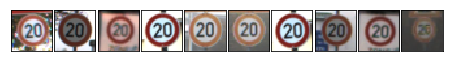

--------------------------------------------------------------------------------------

Class 1: Speed limit (30km/h)                                1980 samples


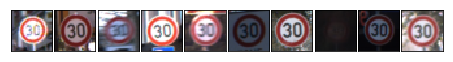

--------------------------------------------------------------------------------------

Class 2: Speed limit (50km/h)                                2010 samples


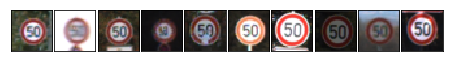

--------------------------------------------------------------------------------------

Class 3: Speed limit (60km/h)                                1260 samples


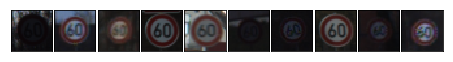

--------------------------------------------------------------------------------------

Class 4: Speed limit (70km/h)                                1770 samples


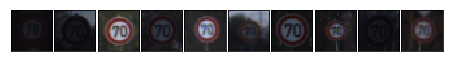

--------------------------------------------------------------------------------------

Class 5: Speed limit (80km/h)                                1650 samples


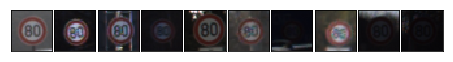

--------------------------------------------------------------------------------------

Class 6: End of speed limit (80km/h)                         360 samples


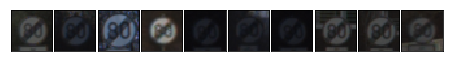

--------------------------------------------------------------------------------------

Class 7: Speed limit (100km/h)                               1290 samples


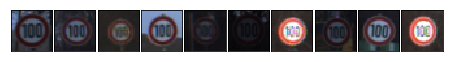

--------------------------------------------------------------------------------------

Class 8: Speed limit (120km/h)                               1260 samples


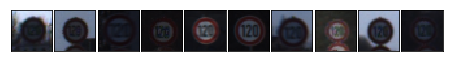

--------------------------------------------------------------------------------------

Class 9: No passing                                          1320 samples


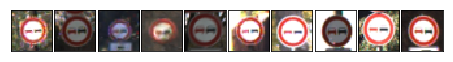

--------------------------------------------------------------------------------------

Class 10: No passing for vechiles over 3.5 metric tons        1800 samples


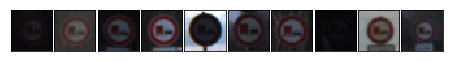

--------------------------------------------------------------------------------------

Class 11: Right-of-way at the next intersection               1170 samples


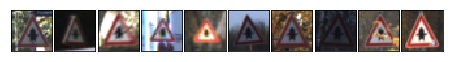

--------------------------------------------------------------------------------------

Class 12: Priority road                                       1890 samples


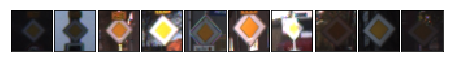

--------------------------------------------------------------------------------------

Class 13: Yield                                               1920 samples


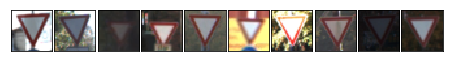

--------------------------------------------------------------------------------------

Class 14: Stop                                                690 samples


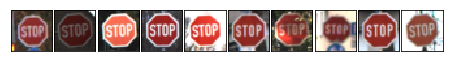

--------------------------------------------------------------------------------------

Class 15: No vechiles                                         540 samples


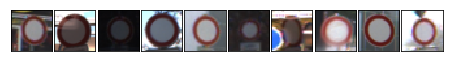

--------------------------------------------------------------------------------------

Class 16: Vechiles over 3.5 metric tons prohibited            360 samples


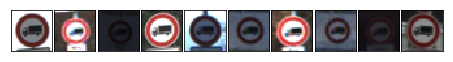

--------------------------------------------------------------------------------------

Class 17: No entry                                            990 samples


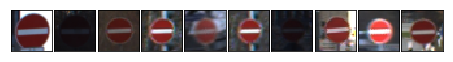

--------------------------------------------------------------------------------------

Class 18: General caution                                     1080 samples


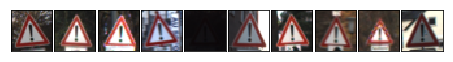

--------------------------------------------------------------------------------------

Class 19: Dangerous curve to the left                         180 samples


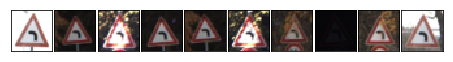

--------------------------------------------------------------------------------------

Class 20: Dangerous curve to the right                        300 samples


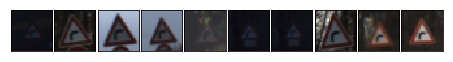

--------------------------------------------------------------------------------------

Class 21: Double curve                                        270 samples


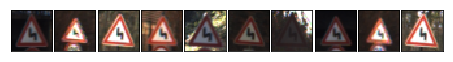

--------------------------------------------------------------------------------------

Class 22: Bumpy road                                          330 samples


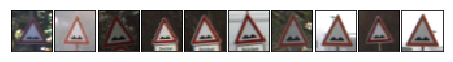

--------------------------------------------------------------------------------------

Class 23: Slippery road                                       450 samples


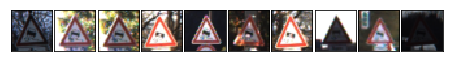

--------------------------------------------------------------------------------------

Class 24: Road narrows on the right                           240 samples


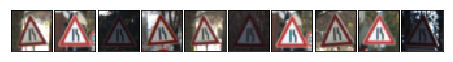

--------------------------------------------------------------------------------------

Class 25: Road work                                           1350 samples


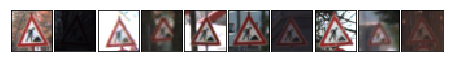

--------------------------------------------------------------------------------------

Class 26: Traffic signals                                     540 samples


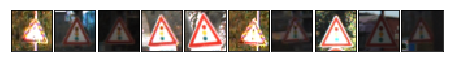

--------------------------------------------------------------------------------------

Class 27: Pedestrians                                         210 samples


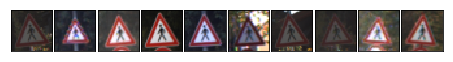

--------------------------------------------------------------------------------------

Class 28: Children crossing                                   480 samples


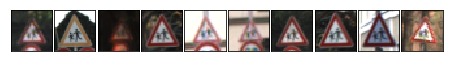

--------------------------------------------------------------------------------------

Class 29: Bicycles crossing                                   240 samples


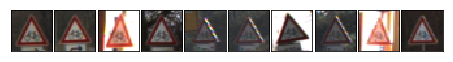

--------------------------------------------------------------------------------------

Class 30: Beware of ice/snow                                  390 samples


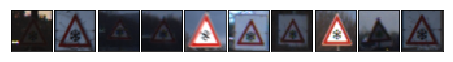

--------------------------------------------------------------------------------------

Class 31: Wild animals crossing                               690 samples


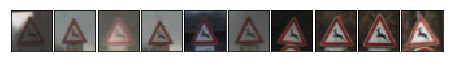

--------------------------------------------------------------------------------------

Class 32: End of all speed and passing limits                 210 samples


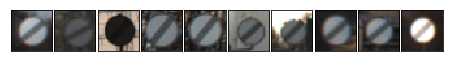

--------------------------------------------------------------------------------------

Class 33: Turn right ahead                                    599 samples


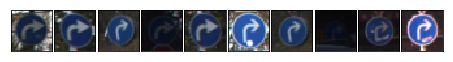

--------------------------------------------------------------------------------------

Class 34: Turn left ahead                                     360 samples


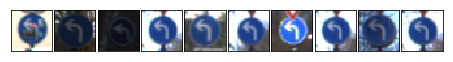

--------------------------------------------------------------------------------------

Class 35: Ahead only                                          1080 samples


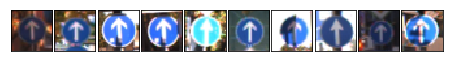

--------------------------------------------------------------------------------------

Class 36: Go straight or right                                330 samples


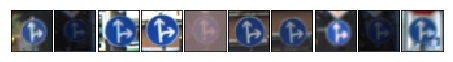

--------------------------------------------------------------------------------------

Class 37: Go straight or left                                 180 samples


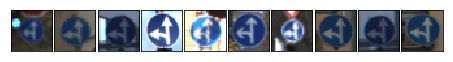

--------------------------------------------------------------------------------------

Class 38: Keep right                                          1860 samples


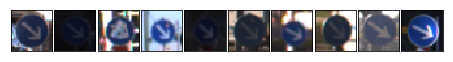

--------------------------------------------------------------------------------------

Class 39: Keep left                                           270 samples


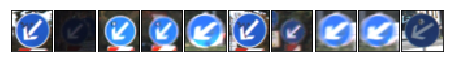

--------------------------------------------------------------------------------------

Class 40: Roundabout mandatory                                300 samples


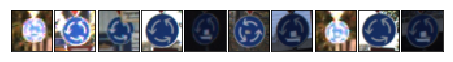

--------------------------------------------------------------------------------------

Class 41: End of no passing                                   210 samples


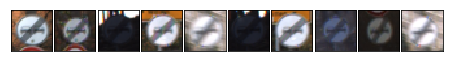

--------------------------------------------------------------------------------------

Class 42: End of no passing by vechiles over 3.5 metric tons  210 samples


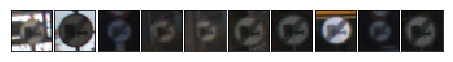

--------------------------------------------------------------------------------------



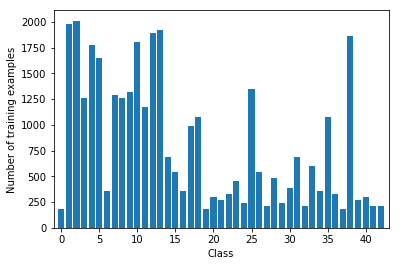

In [5]:
import random

col_width = max(len(name) for name in signnames)

for c, c_index, c_count in zip(sign_classes, class_indices, class_counts):
    print("Class %i: %-*s  %s samples" % (c, col_width, signnames[c], str(c_count)))
    fig = pyplot.figure(figsize = (6, 1))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
    random_indices = random.sample(range(c_index, c_index + c_count), 10)
    for i in range(10):
        axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
        axis.imshow(X_train[random_indices[i]])
    pyplot.show()
    print("--------------------------------------------------------------------------------------\n")
    
pyplot.bar( np.arange( 43 ), class_counts, align='center' )
pyplot.xlabel('Class')
pyplot.ylabel('Number of training examples')
pyplot.xlim([-1, 43])
pyplot.show()

Some classes are highly underrepresented. Overall amount of data is disappointing: some classes have as little as 210 samples, this won't be enough for most of the models to generalise well.

Images with some signs are horizontally and/or vertically symmetrical (like **Bumpy road** or **Ahead only**), and can be simply flipped, thus allowing us to get twice as much data for these classes. 

Other signs come in kind of interchageable pairs, like **Keep right** and **Keep left**: those signs can be flipped and assigned to a paired class. In some cases (like **Keep right** and **Keep left**) we increase the number of samples for **Keep left** from 300 to 2370!

CNNs have built-in invariance to small translations, scaling and rotations. The training set doesn't seem to contain those deformations, so we will add those in our data augmentation step as well.

----

## Model Architecture

Some useful logging routines.

In [6]:
import sys
import time

def get_time_hhmmss(start = None):
    """
    Calculates time since `start` and formats as a string.
    """
    if start is None:
        return time.strftime("%Y/%m/%d %H:%M:%S")
    end = time.time()
    m, s = divmod(end - start, 60)
    h, m = divmod(m, 60)
    time_str = "%02d:%02d:%02d" % (h, m, s)
    return time_str   

# Print iterations progress
def print_progress(iteration, total):
    """
    Call in a loop to create terminal progress bar
    
    Parameters
    ----------
        
    iteration : 
                Current iteration (Int)
    total     : 
                Total iterations (Int)
    """
    str_format = "{0:.0f}"
    percents = str_format.format(100 * (iteration / float(total)))
    filled_length = int(round(100 * iteration / float(total)))
    bar = '█' * filled_length + '-' * (100 - filled_length)

    sys.stdout.write('\r |%s| %s%%' % (bar, percents)),

    if iteration == total:
        sys.stdout.write('\n')
    sys.stdout.flush()

Preprocessing routines.

In [7]:
from sklearn.utils import shuffle
from skimage import exposure
import warnings

num_classes = 43

def preprocess_dataset(X, y = None):
    """
    Performs feature scaling, one-hot encoding of labels and shuffles the data if labels are provided.
    Assumes original dataset is sorted by labels.
    
    Parameters
    ----------
    X                : ndarray
                       Dataset array containing feature examples.
    y                : ndarray, optional, defaults to `None`
                       Dataset labels in index form.
    Returns
    -------
    A tuple of X and y.    
    """
    print("Preprocessing dataset with {} examples:".format(X.shape[0]))

    #Convert to grayscale, e.g. single channel Y
    #X = 0.299 * X[:, :, :, 0] + 0.587 * X[:, :, :, 1] + 0.114 * X[:, :, :, 2]
    #Scale features to be in [0, 1]
    X = (X / 255.).astype(np.float32)
        
    for i in range(X.shape[0]):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            # Remove preprocessing with equal_adapthist
            #X[i] = exposure.equalize_adapthist(X[i])
        print_progress(i + 1, X.shape[0])
        
    if y is not None:  
        # Convert to one-hot encoding. Convert back with `y = y.nonzero()[1]`
        y = np.eye(num_classes)[y]
        X, y = shuffle(X, y)

    # Add a single grayscale channel
    #X = X.reshape(X.shape + (1,)) 
    return X, y

def class_name(one_hot):
    return signnames[one_hot.nonzero()[0][0]]

def load_and_process_data(pickled_data_file):
    """
    Loads pickled data and preprocesses images and labels by scaling features, 
    shuffling the data and applying one-hot encoding to labels.
    
    Parameters
    ----------
    pickled_data_file  : string
                         Pickled data file name.
    Returns
    -------
    A tuple of X and y containing preloaded and preprocessed features and labels respectively.    
    """
    X, y = load_pickled_data(pickled_data_file, columns = ['features', 'labels'])
    X, y = preprocess_dataset(X, y)
    return (X, y)

Data augmentation.

In [8]:
from nolearn.lasagne import BatchIterator
from skimage.transform import rotate
from skimage.transform import warp
from skimage.transform import ProjectiveTransform
from skimage.exposure import adjust_gamma
import random

class AugmentedSignsBatchIterator(BatchIterator):
    """
    Iterates over dataset in batches. 
    Allows images augmentation by randomly rotating, applying projection, 
    adjusting gamma, blurring, adding noize and flipping horizontally.
    """
        
    def __init__(self, batch_size, shuffle = False, seed = 42, p = 0.5, intensity = 0.5):
        """
        Initialises an instance with usual iterating settings, as well as data augmentation coverage
        and augmentation intensity.
        
        Parameters
        ----------
        batch_size:
                    Size of the iteration batch.
        shuffle   :
                    Flag indicating if we need to shuffle the data.
        seed      :
                    Random seed.
        p         :
                    Probability of augmenting a single example, should be in a range of [0, 1] .
                    Defines data augmentation coverage.
        intensity :
                    Augmentation intensity, should be in a [0, 1] range.
        
        Returns
        -------
        New batch iterator instance.
        """
        super(AugmentedSignsBatchIterator, self).__init__(batch_size, shuffle, seed)
        self.p = p
        self.intensity = intensity

    def transform(self, Xb, yb):
        """
        Applies a pipeline of randomised transformations for data augmentation.
        """
        Xb, yb = super(AugmentedSignsBatchIterator, self).transform(
            Xb if yb is None else Xb.copy(), 
            yb
        )
        
        if yb is not None:
            batch_size = Xb.shape[0]
            image_size = Xb.shape[1]
            
            Xb = self.rotate(Xb, batch_size)
            Xb = self.apply_projection_transform(Xb, batch_size, image_size)
            # Include brightness adjustment
            #Xb = self.adjust_brightness(Xb, batch_size)

        return Xb, yb
        
    def rotate(self, Xb, batch_size):
        """
        Applies random rotation in a defined degrees range to a random subset of images. 
        Range itself is subject to scaling depending on augmentation intensity.
        """
        for i in np.random.choice(batch_size, int(batch_size * self.p), replace = False):
            delta = 30. * self.intensity # scale by self.intensity
            Xb[i] = rotate(Xb[i], random.uniform(-delta, delta), mode = 'edge')
        return Xb   
    
    def apply_projection_transform(self, Xb, batch_size, image_size):
        """
        Applies projection transform to a random subset of images. Projection margins are randomised in a range
        depending on the size of the image. Range itself is subject to scaling depending on augmentation intensity.
        """
        d = image_size * 0.3 * self.intensity
        for i in np.random.choice(batch_size, int(batch_size * self.p), replace = False):        
            tl_top = random.uniform(-d, d)     # Top left corner, top margin
            tl_left = random.uniform(-d, d)    # Top left corner, left margin
            bl_bottom = random.uniform(-d, d)  # Bottom left corner, bottom margin
            bl_left = random.uniform(-d, d)    # Bottom left corner, left margin
            tr_top = random.uniform(-d, d)     # Top right corner, top margin
            tr_right = random.uniform(-d, d)   # Top right corner, right margin
            br_bottom = random.uniform(-d, d)  # Bottom right corner, bottom margin
            br_right = random.uniform(-d, d)   # Bottom right corner, right margin

            transform = ProjectiveTransform()
            transform.estimate(np.array((
                    (tl_left, tl_top),
                    (bl_left, image_size - bl_bottom),
                    (image_size - br_right, image_size - br_bottom),
                    (image_size - tr_right, tr_top)
                )), np.array((
                    (0, 0),
                    (0, image_size),
                    (image_size, image_size),
                    (image_size, 0)
                )))
            Xb[i] = warp(Xb[i], transform, output_shape=(image_size, image_size), order = 1, mode = 'edge')

        return Xb
    
    def adjust_brightness(self, Xb, batch_size):
        
        for i in np.random.choice(batch_size, int(batch_size * self.p), replace = False):
            delta = 1. * self.intensity # scale by self.intensity
            Xb[i] = adjust_gamma(Xb[i], random.uniform(1 - delta, 1 + delta))
        return Xb
        

/home/chawins/.conda/envs/tsa/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Let's test data augmentation by plotting first 5 examples next to the original images (original image is on the left).

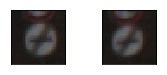

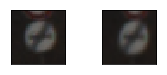

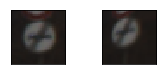

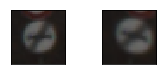

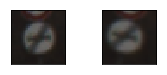

In [9]:
X_train, y_train = load_pickled_data(DIR + "train.p", columns = ['features', 'labels'])
X_train = X_train / 255.

batch_iterator = AugmentedSignsBatchIterator(batch_size = 5, p = 1.0, intensity = 0.5)
for x_batch, y_batch in batch_iterator(X_train, y_train):
    for i in range(5): 
        # plot two images:
        fig = pyplot.figure(figsize=(3, 1))
        axis = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
        axis.imshow(X_train[i])
        axis = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
        axis.imshow(x_batch[i])
        pyplot.show()
    break

A couple of functions for preprocessing our dataset. We may only need to call them once, then pickle resulting balanced dataset and keep using that pickle from then on.

In [10]:
def flip_extend(X, y):
    """
    Extends existing images dataset by flipping images of some classes. As some images would still belong
    to same class after flipping we extend such classes with flipped images. Images of other would toggle 
    between two classes when flipped, so for those we extend existing datasets as well.
    
    Parameters
    ----------
    X       : ndarray
              Dataset array containing feature examples.
    y       : ndarray, optional, defaults to `None`
              Dataset labels in index form.

    Returns
    -------
    A tuple of X and y.    
    """
    # Classes of signs that, when flipped horizontally, should still be classified as the same class
    self_flippable_horizontally = np.array([11, 12, 13, 15, 17, 18, 22, 26, 30, 35])
    # Classes of signs that, when flipped vertically, should still be classified as the same class
    self_flippable_vertically = np.array([1, 5, 12, 15, 17])
    # Classes of signs that, when flipped horizontally and then vertically, should still be classified as the same class
    self_flippable_both = np.array([32, 40])
    # Classes of signs that, when flipped horizontally, would still be meaningful, but should be classified as some other class
    cross_flippable = np.array([
        [19, 20], 
        [33, 34], 
        [36, 37], 
        [38, 39],
        [20, 19], 
        [34, 33], 
        [37, 36], 
        [39, 38],   
    ])
    num_classes = 43
    
    X_extended = np.empty([0, X.shape[1], X.shape[2], X.shape[3]], dtype = X.dtype)
    y_extended = np.empty([0], dtype = y.dtype)
    
    for c in range(num_classes):
        # First copy existing data for this class
        X_extended = np.append(X_extended, X[y == c], axis = 0)
        # If we can flip images of this class horizontally and they would still belong to said class...
        if c in self_flippable_horizontally:
            # ...Copy their flipped versions into extended array.
            X_extended = np.append(X_extended, X[y == c][:, :, ::-1, :], axis = 0)
        # If we can flip images of this class horizontally and they would belong to other class...
        if c in cross_flippable[:, 0]:
            # ...Copy flipped images of that other class to the extended array.
            flip_class = cross_flippable[cross_flippable[:, 0] == c][0][1]
            X_extended = np.append(X_extended, X[y == flip_class][:, :, ::-1, :], axis = 0)
        # Fill labels for added images set to current class.
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype = int))
        
        # If we can flip images of this class vertically and they would still belong to said class...
        if c in self_flippable_vertically:
            # ...Copy their flipped versions into extended array.
            X_extended = np.append(X_extended, X_extended[y_extended == c][:, ::-1, :, :], axis = 0)
        # Fill labels for added images set to current class.
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype = int))
        
        # If we can flip images of this class horizontally AND vertically and they would still belong to said class...
        if c in self_flippable_both:
            # ...Copy their flipped versions into extended array.
            X_extended = np.append(X_extended, X_extended[y_extended == c][:, ::-1, ::-1, :], axis = 0)
        # Fill labels for added images set to current class.
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype = int))
    
    return (X_extended, y_extended)

def extend_balancing_classes(X, y, aug_intensity = 0.5, counts = None):
    """
    Extends dataset by duplicating existing images while applying data augmentation pipeline.
    Number of generated examples for each class may be provided in `counts`.
    
    Parameters
    ----------
    X             : ndarray
                    Dataset array containing feature examples.
    y             : ndarray, optional, defaults to `None`
                    Dataset labels in index form.
    aug_intensity :
                    Intensity of augmentation, must be in [0, 1] range.
    counts        :
                    Number of elements for each class.
                    
    Returns
    -------
    A tuple of X and y.    
    """
    num_classes = 43

    _, class_counts = np.unique(y, return_counts = True)
    max_c = max(class_counts)
    total = max_c * num_classes if counts is None else np.sum(counts)
    
    X_extended = np.empty([0, X.shape[1], X.shape[2], X.shape[3]], dtype = np.float32)
    y_extended = np.empty([0], dtype = y.dtype)
    print("Extending dataset using augmented data (intensity = {}):".format(aug_intensity))
    
    for c, c_count in zip(range(num_classes), class_counts):
        # How many examples should there be eventually for this class:
        max_c = max_c if counts is None else counts[c]
        # First copy existing data for this class
        X_source = (X[y == c] / 255.).astype(np.float32)
        y_source = y[y == c]
        X_extended = np.append(X_extended, X_source, axis = 0)
        for i in range((max_c // c_count) - 1):
            batch_iterator = AugmentedSignsBatchIterator(batch_size = X_source.shape[0], p = 1.0, intensity = aug_intensity)
            for x_batch, _ in batch_iterator(X_source, y_source):
                X_extended = np.append(X_extended, x_batch, axis = 0)
                print_progress(X_extended.shape[0], total)
        batch_iterator = AugmentedSignsBatchIterator(batch_size = max_c % c_count, p = 1.0, intensity = aug_intensity)
        for x_batch, _ in batch_iterator(X_source, y_source):
            X_extended = np.append(X_extended, x_batch, axis = 0)
            print_progress(X_extended.shape[0], total)
            break
        # Fill labels for added images set to current class.
        added = X_extended.shape[0] - y_extended.shape[0]
        y_extended = np.append(y_extended, np.full((added), c, dtype = int))
        
    return ((X_extended * 255.).astype(np.uint8), y_extended)

Prepare extended and balanced training datasets by augmenting original data:

In [11]:
import random
import pickle
from sklearn.cross_validation import train_test_split

train_dataset_file = DIR + "train.p"
test_dataset_file = DIR + "test.p"
train_extended_dataset_file = DIR + "train_extended.p"
train_balanced_dataset_file = DIR + "train_balanced.p"

X_train, y_train = load_pickled_data(train_dataset_file, ['features', 'labels'])
print("Number of training examples in initial dataset =", X_train.shape[0])
_, class_counts = np.unique(y_train, return_counts = True)
X_train, y_train = flip_extend(X_train, y_train)
print("Number of training examples after horizontal flipping =", X_train.shape[0])

# Prepare a dataset with balanced classes
X_train_balanced, y_train_balanced = extend_balancing_classes(X_train, y_train, aug_intensity = 0.75, counts = np.full(43, 20000, dtype = int))
print("Number of training examples after augmenting and balancing training data =", X_train_balanced.shape[0])
pickle.dump({
        "features" : X_train_balanced,
        "labels" : y_train_balanced
    }, open(train_balanced_dataset_file, "wb" ) )
print("Balanced dataset saved in", train_balanced_dataset_file)

# Prepare a dataset with extended classes
# X_train_extended, y_train_extended = extend_balancing_classes(X_train, y_train, aug_intensity = 0.75, counts = class_counts * 20)
# print("Number of training examples after augmenting and extending training data =", X_train_extended.shape[0])
# pickle.dump({
#         "features" : X_train_extended,
#         "labels" : y_train_extended
#     }, open(train_extended_dataset_file, "wb" ) )
# print("Extended dataset saved in", train_extended_dataset_file)

('Number of training examples in initial dataset =', 34799)
('Number of training examples after horizontal flipping =', 59788)
Extending dataset using augmented data (intensity = 0.75):
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100%
('Number of training examples after augmenting and balancing training data =', 860000)
('Balanced dataset saved in', './input_data/train_balanced.p')


Preprocess all datasets:

In [64]:
import pickle

train_extended_dataset_file = "traffic-signs-data/train_extended.p"
train_balanced_dataset_file = "traffic-signs-data/train_balanced.p"
train_extended_preprocessed_dataset_file = "traffic-signs-data/train_extended_preprocessed.p"
train_balanced_preprocessed_dataset_file = "traffic-signs-data/train_balanced_bright_75.p"

test_dataset_file = "traffic-signs-data/test.p"
test_preprocessed_dataset_file = "traffic-signs-data/test_preprocessed.p"

val_dataset_file = "traffic-signs-data/valid.p"
val_preprocessed_dataset_file = "traffic-signs-data/valid_preprocessed.p"

X_train, y_train = load_and_process_data(train_balanced_dataset_file)
pickle.dump({
        "features" : X_train,
        "labels" : y_train
    }, open(train_balanced_preprocessed_dataset_file, "wb" ) )
print("Preprocessed balanced training dataset saved in", train_balanced_preprocessed_dataset_file)

# X_train, y_train = load_and_process_data(train_extended_dataset_file)
# pickle.dump({
#         "features" : X_train,
#         "labels" : y_train
#     }, open(train_extended_preprocessed_dataset_file, "wb" ) )
# print("Preprocessed extended training dataset saved in", train_extended_preprocessed_dataset_file)

# X_test, y_test = load_and_process_data(test_dataset_file)
# pickle.dump({
#         "features" : X_test,
#         "labels" : y_test
#     }, open(test_preprocessed_dataset_file, "wb" ) )
# print("Preprocessed extended testing dataset saved in", test_preprocessed_dataset_file)

# X_val, y_val = load_and_process_data(val_dataset_file)
# pickle.dump({
#         "features" : X_val,
#         "labels" : y_val
#     }, open(val_preprocessed_dataset_file, "wb" ) )
# print("Preprocessed extended validate dataset saved in", val_preprocessed_dataset_file)

Preprocessing dataset with 860000 examples:
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100%
('Preprocessed balanced training dataset saved in', 'traffic-signs-data/train_balanced_bright_75.p')
